# Preparing the data

In [1]:
%cd /home/shuaman/repucs/PSL-GAN
%load_ext autoreload
%autoreload 2

/home/shuaman/repucs/PSL-GAN


In [2]:
from platform import python_version

print(python_version())

3.8.11


In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings("ignore")
import missingno as msno

In [4]:
from utils.utils_getdata import *
from create_dataset import *

In [5]:
pd.options.display.max_columns = 300

In [6]:
width_frames = height_frames = 256

In [7]:
path_data = "/data/shuaman/psl_gan/Data/landmarks"

name_aec_mp = "AEC--mediapipe.pk"
name_aec_wp = "AEC--wholepose.pk"
name_pucp_mp = "PUCP_PSL_DGI156--mediapipe.pk"

In [8]:
df_aec_mp = pd.read_pickle(os.path.join(path_data, name_aec_mp)).T
print(df_aec_mp.shape)
df_aec_mp.head(2)

(2310, 3)


,data,label,name
0,[[{'pose': [[0.47449803 0.18475646] [0.487047...,sí,sí_634.mp4
1,[[{'pose': [[0.45426351 0.20800602] [0.486233...,acuerdo,acuerdo_201.mp4


In [9]:
df_aec_wp = pd.read_pickle(os.path.join(path_data, name_aec_wp)).T
print(df_aec_mp.shape)
df_aec_wp.head(2)

(2310, 3)


,data,label,name
0,"[[[[0.47265625 0.17578125], [0.49609375 0.1523...",sí,sí_634.mp4
1,"[[[[0.43359375 0.19921875], [0.48046875 0.1679...",acuerdo,acuerdo_201.mp4


In [10]:
assert df_aec_mp.shape[0]==df_aec_wp.shape[0] and df_aec_mp[-df_aec_mp.name.isin(df_aec_wp.name.unique())].name.nunique()==0 and df_aec_wp[-df_aec_wp.name.isin(df_aec_mp.name.unique())].name.nunique()==0, "The data is bad, the videos are not the same"

In [11]:
df_pucp_mp = pd.read_pickle(os.path.join(path_data, name_pucp_mp)).T
print(df_pucp_mp.shape)
df_pucp_mp.head(2)

(3684, 3)


,data,label,name
0,[[{'pose': [[0.35491899 0.3058005 ] [0.390940...,ahí,AHÍ_2311.mp4
1,[[{'pose': [[0.41666716 0.29213896] [0.455572...,mujer,MUJER_2233.mp4


In [12]:
import itertools
import sys

In [13]:
print(len(df_aec_wp.name.unique()))
for videoname in df_aec_wp.name.unique():
    data_video = df_aec_wp.loc[df_aec_wp.name==videoname].data.values[0][0]
    print(len(data_video))
    for n_frame, data_frame in enumerate(data_video):
        print(len(data_frame))
        for pos, landmark in enumerate(data_frame):
            print(len(landmark))
            break
        #for 
        break
    break

2310
8
133
2


In [14]:
def process_raw_data(df_in,
                     width_frames,
                     height_frames,
                    type_lm: str="MP"):
    df = df_in.copy()
    
    assert df.shape[0]==df.name.nunique(), "There are repeated videnames"
    
    list_videoname = []
    list_frames = []
    list_X = []
    list_Y = []
    list_pos = []
    list_label = []
    
    for videoname in df.name.unique():
        label = df.loc[df.name==videoname].label.values[0]
        data_video = df.loc[df.name==videoname].data.values[0][0]
        for n_frame, data_frame in enumerate(data_video):
            if type_lm=="MP":
                landmarks = []
                for body_location in data_frame.keys():
                    landmarks.append(data_frame[body_location])
                landmarks = list(itertools.chain(*landmarks))
            elif type_lm=="WP":
                landmarks = data_frame
            else:
                print("This is not a valid landmark type")
                sys.exit(0)
            for pos,landmark in enumerate(landmarks):
                list_X.append(landmark[0])
                list_Y.append(landmark[1])
                list_pos.append(pos)
                list_frames.append(n_frame)
                list_videoname.append(videoname)
                list_label.append(label)
                    
    
    data = {
            "videoname": list_videoname,
            "n_frame": list_frames,
            "n_landmark": list_pos,
            "x": list_X,
            "y": list_Y,
            "class": list_label
        }
    
    df = pd.DataFrame(data) 

    print(f"{df.shape=}")
    print(f"{df.videoname.nunique()=}")

    df['out_range?'] = (df['x']<=0) | (df['y']<=0) | (df['x']*width_frames>=width_frames) | (df['y']*height_frames>=height_frames)
    
    df_corr = df.loc[(df['out_range?']==False) &
                    (df['class']!="???"), :].reset_index(drop=True)
    

    print(f"{df_corr.shape=}")
    print(f"{df_corr.videoname.nunique()=}")
    
    return df, df_corr
    

In [15]:
def get_process_data(path_or, path_or_corr, df_mp, type_lm,
                      width_frames,
                     height_frames,
                     read_backup=True):
    if read_backup and os.path.exists(path_or) and os.path.exists(path_or_corr):
        print("Reading backup")
        df_mp_or = pd.read_csv(path_or)
        df_mp_or_corr = pd.read_csv(path_or_corr)
        
        print(f"{df_mp_or.shape=}")
        print(f"{df_mp_or.videoname.nunique()=}")
        print(f"{df_mp_or_corr.shape=}")
        print(f"{df_mp_or_corr.videoname.nunique()=}")
    
    else:
        print("Generating from scratch")
        df_mp_or, df_mp_or_corr  = process_raw_data(df_mp, width_frames, height_frames, type_lm)
        print("Saving to backup")
        df_mp_or.to_csv(path_or, header=True, index=False)
        df_mp_or_corr.to_csv(path_or_corr, header=True, index=False)
    

    
    return df_mp_or, df_mp_or_corr

In [58]:
path_aec_mp_or = os.path.join(path_data, "df_aec_mp_or.csv")
path_aec_mp_or_corr = os.path.join(path_data, "df_aec_mp_or_corr.csv")

df_aec_mp_or, df_aec_mp_or_corr  = get_process_data(path_aec_mp_or, path_aec_mp_or_corr, 
                                                    df_aec_mp, type_lm="MP",
                                                     width_frames=width_frames,
                                                     height_frames=height_frames,
                                                    read_backup=True)

Generating from scratch
df.shape=(18753591, 6)
df.videoname.nunique()=2310
df_corr.shape=(17842890, 7)
df_corr.videoname.nunique()=2287
Saving to backup


In [17]:
path_pucp_mp_or = os.path.join(path_data, "df_pucp_mp_or.csv")
path_pucp_mp_or_corr = os.path.join(path_data, "df_pucp_mp_or_corr.csv")

df_pucp_mp_or, df_pucp_mp_or_corr  = get_process_data(path_pucp_mp_or, path_pucp_mp_or_corr, 
                                                      df_pucp_mp, type_lm="MP",
                                                      width_frames=width_frames,
                                                     height_frames=height_frames,
                                                    read_backup=True)

Generating from scratch
df.shape=(39724794, 6)
df.videoname.nunique()=3684
df_corr.shape=(37479402, 7)
df_corr.videoname.nunique()=3682
Saving to backup


In [18]:
path_aec_wp_or = os.path.join(path_data, "df_aec_wp_or.csv")
path_aec_wp_or_corr = os.path.join(path_data, "df_aec_wp_or_corr.csv")

df_aec_wp_or, df_aec_wp_or_corr  = get_process_data(path_aec_wp_or, path_aec_wp_or_corr, 
                                                    df_aec_wp, type_lm="WP",
                                                    width_frames=width_frames,
                                                     height_frames=height_frames,
                                                    read_backup=True)

Generating from scratch
df.shape=(4593421, 6)
df.videoname.nunique()=2310
df_corr.shape=(4533052, 7)
df_corr.videoname.nunique()=2287
Saving to backup


In [19]:
df_aec_wp_or.head(1)

,videoname,n_frame,n_landmark,x,y,class,out_range?
0,sí_634.mp4,0,0,0.472656,0.175781,sí,False


In [56]:
df_pucp_mp_or_corr.y.min()

1.6294419765472412e-05

In [57]:
df_pucp_mp_or_corr.y.max()

0.9999996423721313

# Detecting bad data in Whole Pose Dataset

In [22]:
n_landmarks = 27

In [23]:
df_aec_mp_or.head(1)

,videoname,n_frame,n_landmark,x,y,class,out_range?
0,sí_634.mp4,0,0,0.474498,0.184756,sí,False


In [24]:
df_aec_mp_or["n_landmark"].max()

542

In [25]:
LIST_LANDMARKS = LIST_LANDMARKS_dict[str(n_landmarks)]
LIST_LHAND_MEDIAPIPE = LIST_LHAND_MEDIAPIPE_dict[str(n_landmarks)]
LIST_RHAND_MEDIAPIPE = LIST_RHAND_MEDIAPIPE_dict[str(n_landmarks)]
LIST_LANDMARKS_COCO = LIST_LANDMARKS_COCO_dict[str(n_landmarks)]

max_landmark = df_aec_mp_or["n_landmark"].max()

list_landmarks_mp = LIST_LANDMARKS + [i + N_POSE_LANDMARKS for i in LIST_LHAND_MEDIAPIPE]
list_landmarks_mp = list_landmarks_mp + [i + N_POSE_LANDMARKS + N_LHAND_LANDMARKS for i in LIST_RHAND_MEDIAPIPE]
list_landmarks_coco_converted = [i + max_landmark + 1 for i in LIST_LANDMARKS_COCO]
list_landmarks_total = list_landmarks_mp + list_landmarks_coco_converted

# AEC dataset

## Filtering incorrect data

In [26]:
#df_analisis = df_aec_mp_or
#df_analisis_corr = df_aec_mp_or_corr

In [27]:
#df_analisis_corr.head(2)

In [28]:
df_or = pd.concat([df_aec_mp_or_corr[["videoname", "n_frame", "n_landmark",
                                "x", "y", "class"]]]).reset_index(drop=True)
print(df_or.shape)
df_or.head()

(17842890, 6)


,videoname,n_frame,n_landmark,x,y,class
0,sí_634.mp4,0,0,0.474498,0.184756,sí
1,sí_634.mp4,0,1,0.487048,0.154266,sí
2,sí_634.mp4,0,2,0.504110,0.155415,sí
3,sí_634.mp4,0,3,0.514052,0.155474,sí
4,sí_634.mp4,0,4,0.442415,0.153642,sí


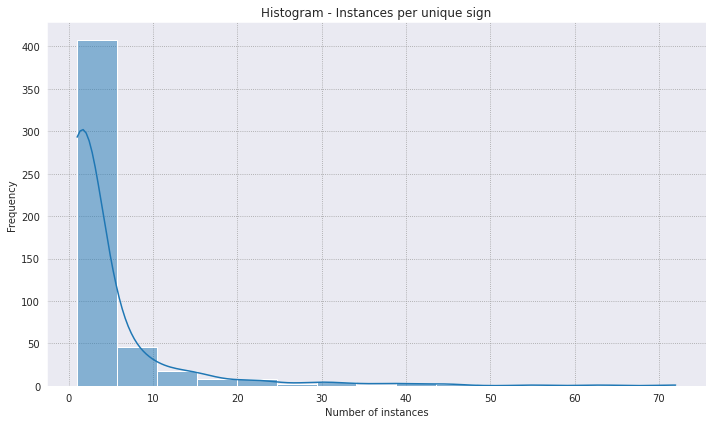

In [29]:
#plt.set(title='Histogram', xlabel='Height (cm)', ylabel='Count')

# sns.set_style("whitegrid")
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
# sns.set_theme()
plt.figure(figsize=(10,6), tight_layout=True)
plt.title("Histogram - Instances per unique sign")
plt.xlabel("Number of instances")
plt.ylabel("Frequency")
sns.histplot(data=df_or.groupby(["class"]).videoname.nunique().reset_index(), x="videoname", kde=True, bins=15,
                )
plt.savefig("histogram_ninstances.png")
plt.show()


In [30]:
print()
print("Original")
print(f"Shape {df_or.shape} - N classes", df_or["class"].nunique(), 
    " - Number of videos", df_or["videoname"].nunique())



Original
Shape (17842890, 6) - N classes 504  - Number of videos 2287


## Filtering Landmarks

In [31]:
list_landmarks_mp

[0,
 2,
 5,
 11,
 12,
 13,
 14,
 15,
 16,
 21,
 22,
 38,
 41,
 42,
 45,
 46,
 49,
 50,
 53,
 59,
 62,
 63,
 66,
 67,
 70,
 71,
 74]

In [32]:
df_or, df_flag_lm_orig, df_flag_lm, df_flag_lm_v = filter_landmarks(df_or, list_landmarks_mp, list_landmarks_coco_converted, use_coco=False)


Use coco False

Filter: list of landmarks
Shape (824725, 8) - N classes 504  - Number of videos 2287

Filter: frames that have all landmarks
Shape (638226, 8) - N classes 494  - Number of videos 2110

Filter: videos which all frames have those landmarks
Shape (191511, 8) - N classes 202  - Number of videos 553


In [33]:
df_flag_lm_orig.head(1)

,n_landmark,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,...,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542
videoname,n_frame,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-adulto_2196.mp4,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [34]:
df_flag_lm_orig.shape

(34086, 535)

In [35]:
dict_rename_columns = {
    0: "nose",
    2: "left_eye",
    5: "right_eye",
    11: "left_shoulder",
    12: "right_shoulder",
    13: "left_elbow",
    14: "right_elbow",
    15: "left_wrist",
    16: "right_wrist",
    21: "left_thumb",
    22: "right_thumb",
    
    38: "left_index_finger_mcp",
    41: "left_index_finger_tip",
    42: "left_middle_finger_mcp",
    45: "left_middle_finger_tip",
    46: "left_ring_finger_mcp",
    49: "left_ring_finger_tip",
    50: "left_pinky_mpc",
    53: "left_pinky_tip",
    
    59: "right_index_finger_mcp",
    62: "right_index_finger_tip",
    63: "right_middle_finger_mcp",
    66: "right_middle_finger_tip",
    67: "right_ring_finger_mcp",
    70: "right_ring_finger_tip",
    71: "right_pinky_mpc",
    74: "right_pinky_tip"
}

In [36]:
list_landmarks_mp_names = [dict_rename_columns[i] for i in list_landmarks_mp]

## Missing Values Analysis of MediaPipe Landmarks

In [37]:
df_flag_lm_orig = df_flag_lm_orig.rename(columns=dict_rename_columns)

In [38]:
df_flag_lm_orig.head(1)

,n_landmark,nose,1,left_eye,3,4,right_eye,6,7,8,9,10,left_shoulder,right_shoulder,left_elbow,right_elbow,left_wrist,right_wrist,17,18,19,20,left_thumb,right_thumb,23,24,33,34,35,36,37,left_index_finger_mcp,39,40,left_index_finger_tip,left_middle_finger_mcp,43,44,left_middle_finger_tip,left_ring_finger_mcp,47,48,left_ring_finger_tip,left_pinky_mpc,51,52,left_pinky_tip,54,55,56,57,58,right_index_finger_mcp,60,61,right_index_finger_tip,right_middle_finger_mcp,64,65,right_middle_finger_tip,right_ring_finger_mcp,68,69,right_ring_finger_tip,right_pinky_mpc,72,73,right_pinky_tip,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,...,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542
videoname,n_frame,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-adulto_2196.mp4,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


<AxesSubplot:>

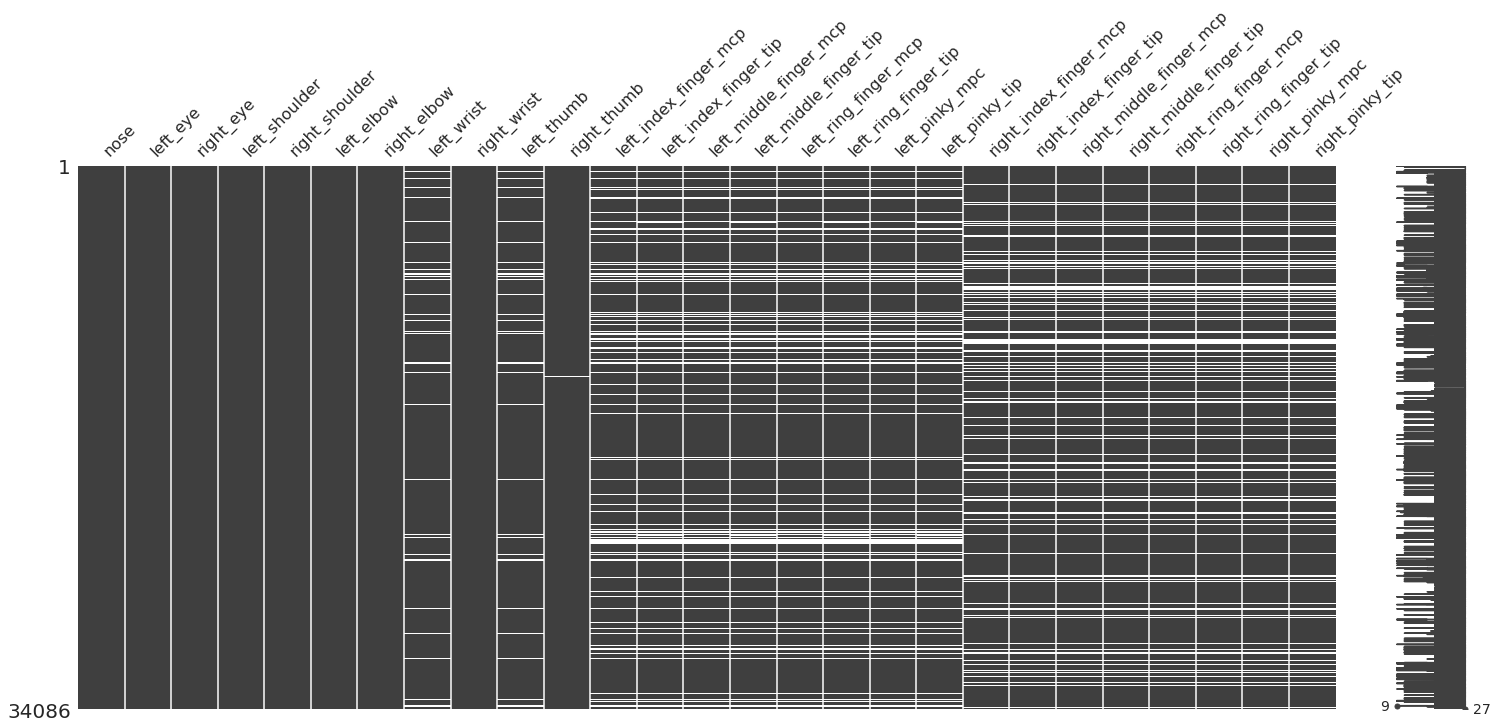

In [39]:
msno.matrix(df_flag_lm_orig[list_landmarks_mp_names])

<AxesSubplot:xlabel='n_landmark', ylabel='n_landmark'>

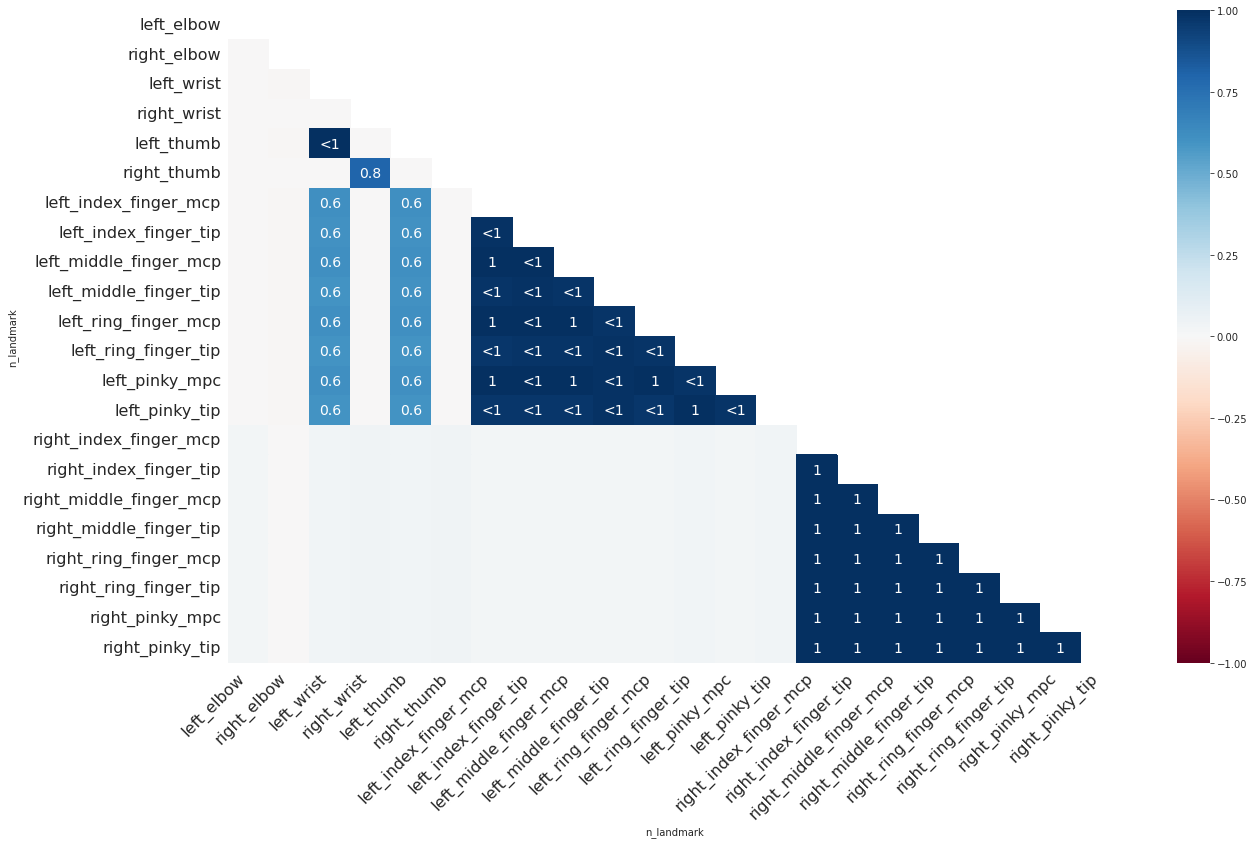

In [40]:
msno.heatmap(df_flag_lm_orig[list_landmarks_mp_names])

<AxesSubplot:>

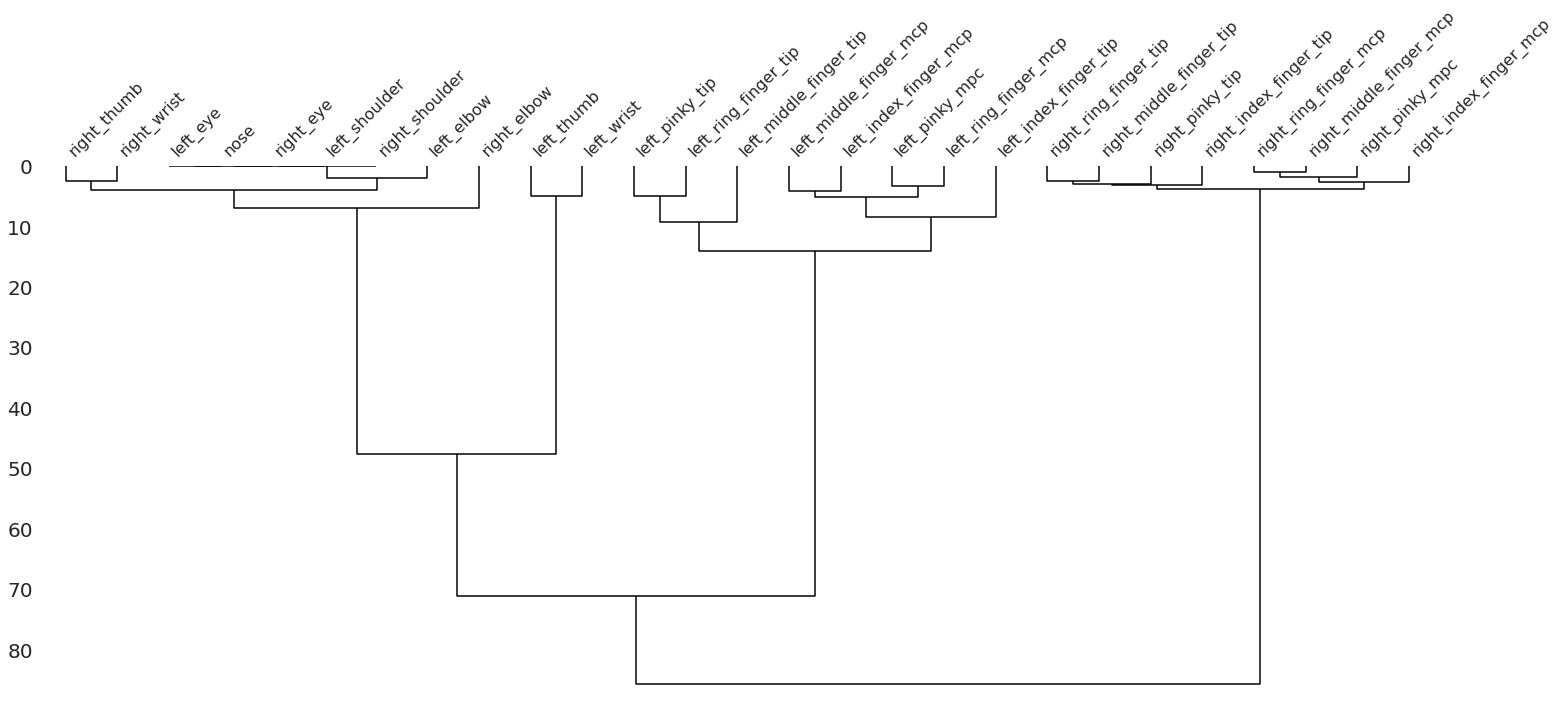

In [41]:
msno.dendrogram(df_flag_lm_orig[list_landmarks_mp_names])

# PUCP dataset

## Filtering incorrect data

In [42]:
df_or = pd.concat([df_pucp_mp_or_corr[["videoname", "n_frame", "n_landmark",
                                "x", "y", "class"]]]).reset_index(drop=True)
print(df_or.shape)
df_or.head()

(37479402, 6)


,videoname,n_frame,n_landmark,x,y,class
0,AHÍ_2311.mp4,0,0,0.354919,0.305800,ahí
1,AHÍ_2311.mp4,0,1,0.390940,0.255314,ahí
2,AHÍ_2311.mp4,0,2,0.412050,0.254459,ahí
3,AHÍ_2311.mp4,0,3,0.430789,0.254739,ahí
4,AHÍ_2311.mp4,0,4,0.345557,0.259743,ahí


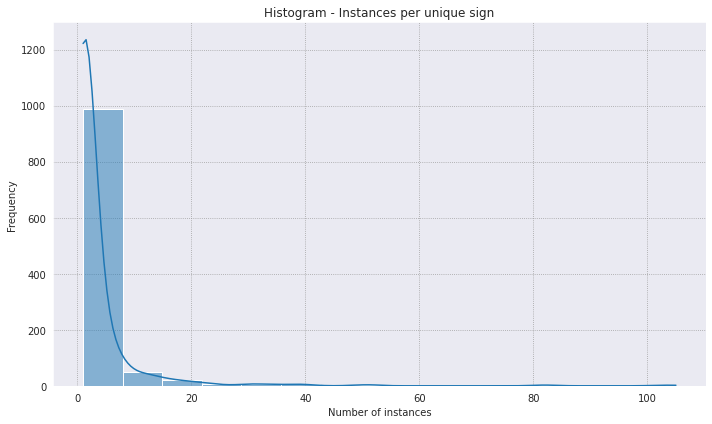

In [43]:
#plt.set(title='Histogram', xlabel='Height (cm)', ylabel='Count')

# sns.set_style("whitegrid")
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
# sns.set_theme()
plt.figure(figsize=(10,6), tight_layout=True)
plt.title("Histogram - Instances per unique sign")
plt.xlabel("Number of instances")
plt.ylabel("Frequency")
sns.histplot(data=df_or.groupby(["class"]).videoname.nunique().reset_index(), x="videoname", kde=True, bins=15,
                )
plt.savefig("histogram_ninstances.png")
plt.show()


In [44]:
print()
print("Original")
print(f"Shape {df_or.shape} - N classes", df_or["class"].nunique(), 
    " - Number of videos", df_or["videoname"].nunique())



Original
Shape (37479402, 6) - N classes 1082  - Number of videos 3682


## Filtering Landmarks

In [45]:
list_landmarks_mp

[0,
 2,
 5,
 11,
 12,
 13,
 14,
 15,
 16,
 21,
 22,
 38,
 41,
 42,
 45,
 46,
 49,
 50,
 53,
 59,
 62,
 63,
 66,
 67,
 70,
 71,
 74]

In [46]:
df_or, df_flag_lm_orig, df_flag_lm, df_flag_lm_v = filter_landmarks(df_or, list_landmarks_mp, list_landmarks_coco_converted, use_coco=False)


Use coco False

Filter: list of landmarks
Shape (1610929, 8) - N classes 1082  - Number of videos 3682

Filter: frames that have all landmarks
Shape (1001079, 8) - N classes 977  - Number of videos 3075

Filter: videos which all frames have those landmarks
Shape (284796, 8) - N classes 303  - Number of videos 652


In [47]:
df_flag_lm_orig.head(1)

,n_landmark,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,...,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542
videoname,n_frame,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"""AH""_3068.mp4",0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [48]:
df_flag_lm_orig.shape

(73123, 543)

## Missing Values Analysis of MediaPipe Landmarks

In [49]:
df_flag_lm_orig = df_flag_lm_orig.rename(columns=dict_rename_columns)

In [50]:
df_flag_lm_orig.head(1)

,n_landmark,nose,1,left_eye,3,4,right_eye,6,7,8,9,10,left_shoulder,right_shoulder,left_elbow,right_elbow,left_wrist,right_wrist,17,18,19,20,left_thumb,right_thumb,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,left_index_finger_mcp,39,40,left_index_finger_tip,left_middle_finger_mcp,43,44,left_middle_finger_tip,left_ring_finger_mcp,47,48,left_ring_finger_tip,left_pinky_mpc,51,52,left_pinky_tip,54,55,56,57,58,right_index_finger_mcp,60,61,right_index_finger_tip,right_middle_finger_mcp,64,65,right_middle_finger_tip,right_ring_finger_mcp,68,69,right_ring_finger_tip,right_pinky_mpc,72,73,right_pinky_tip,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,...,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542
videoname,n_frame,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"""AH""_3068.mp4",0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


<AxesSubplot:>

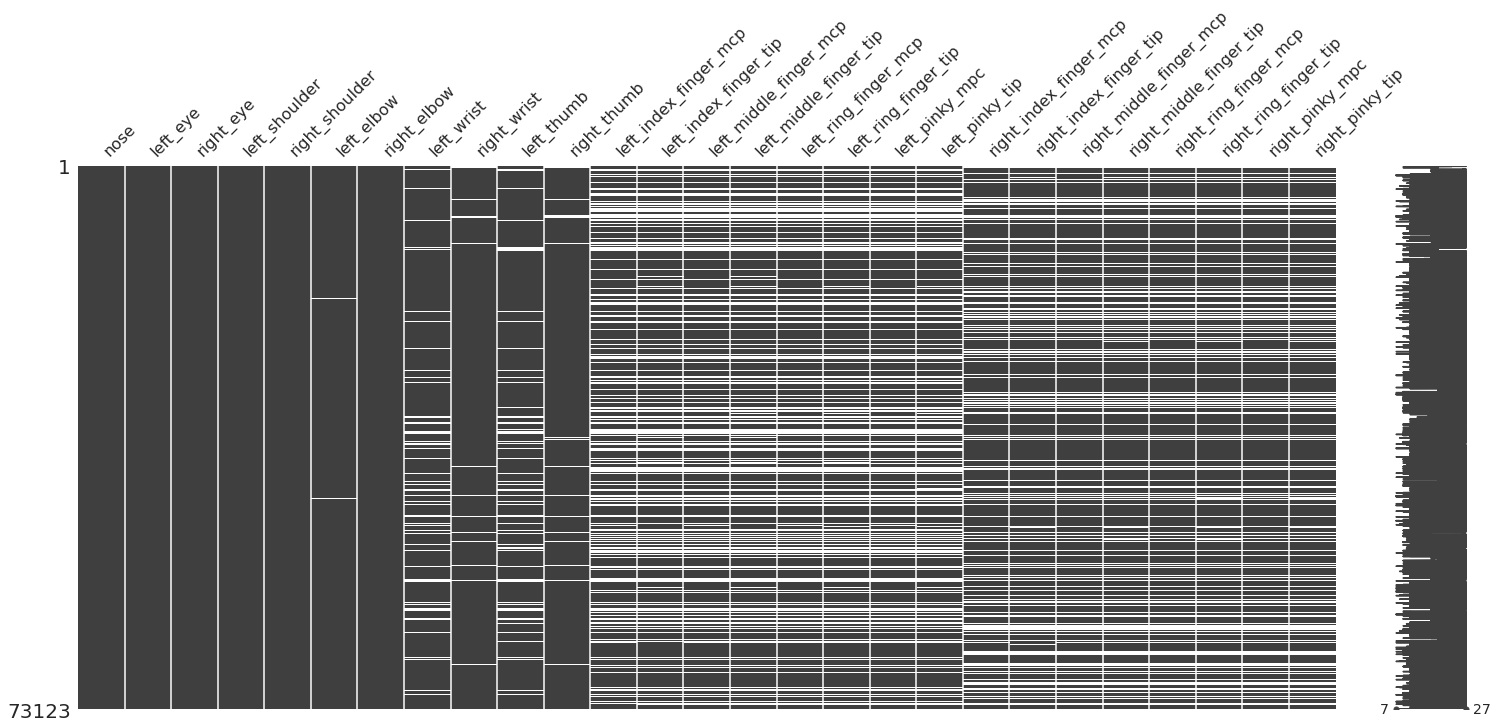

In [51]:
msno.matrix(df_flag_lm_orig[list_landmarks_mp_names])

<AxesSubplot:xlabel='n_landmark', ylabel='n_landmark'>

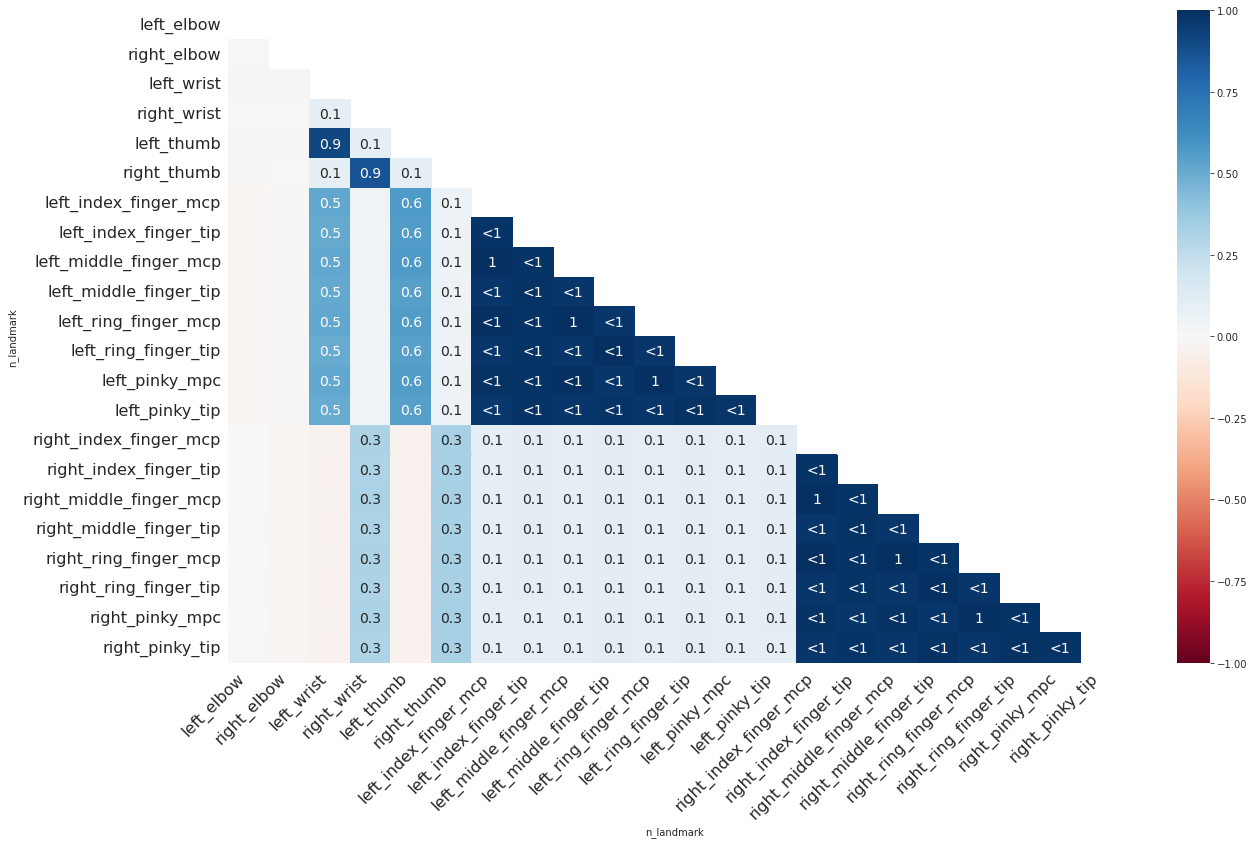

In [52]:
msno.heatmap(df_flag_lm_orig[list_landmarks_mp_names])

<AxesSubplot:>

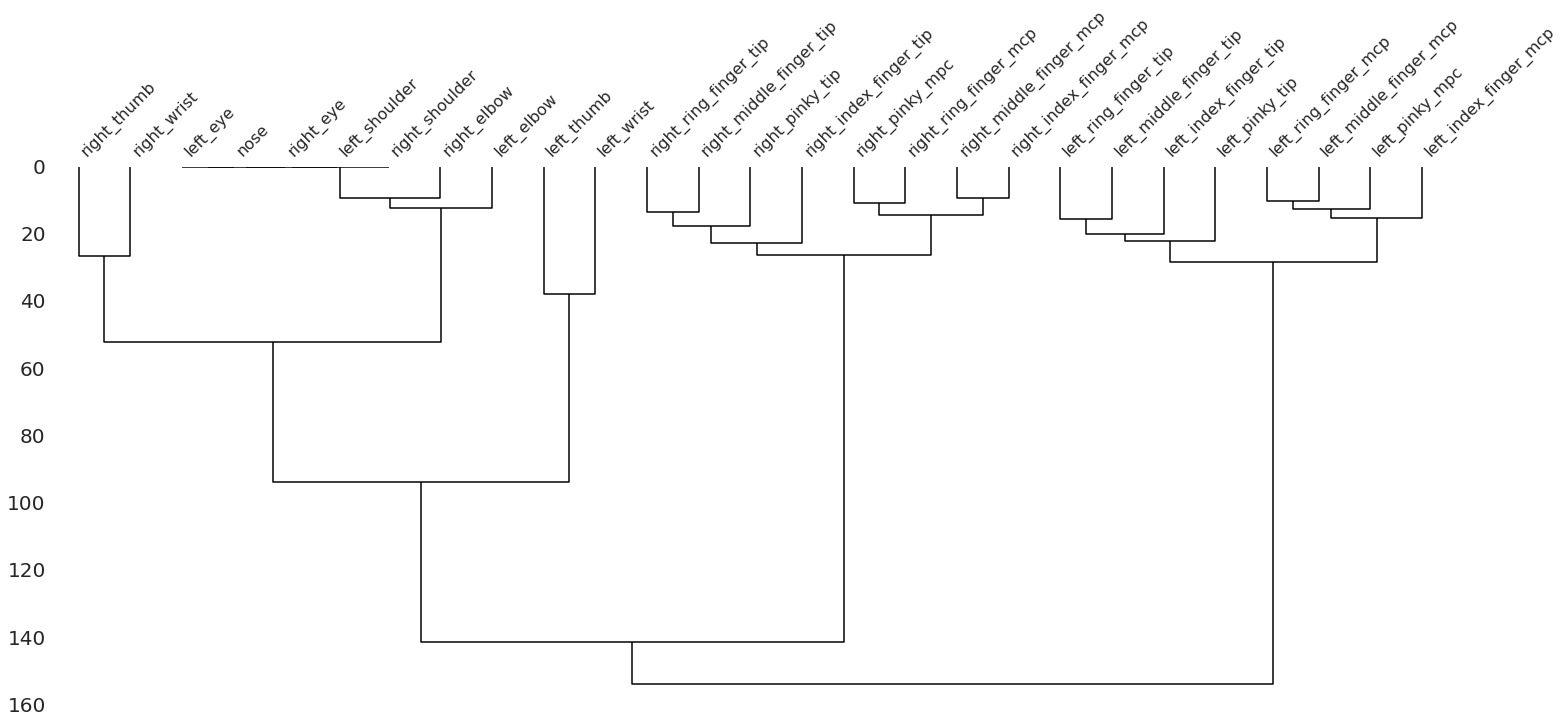

In [53]:
msno.dendrogram(df_flag_lm_orig[list_landmarks_mp_names])